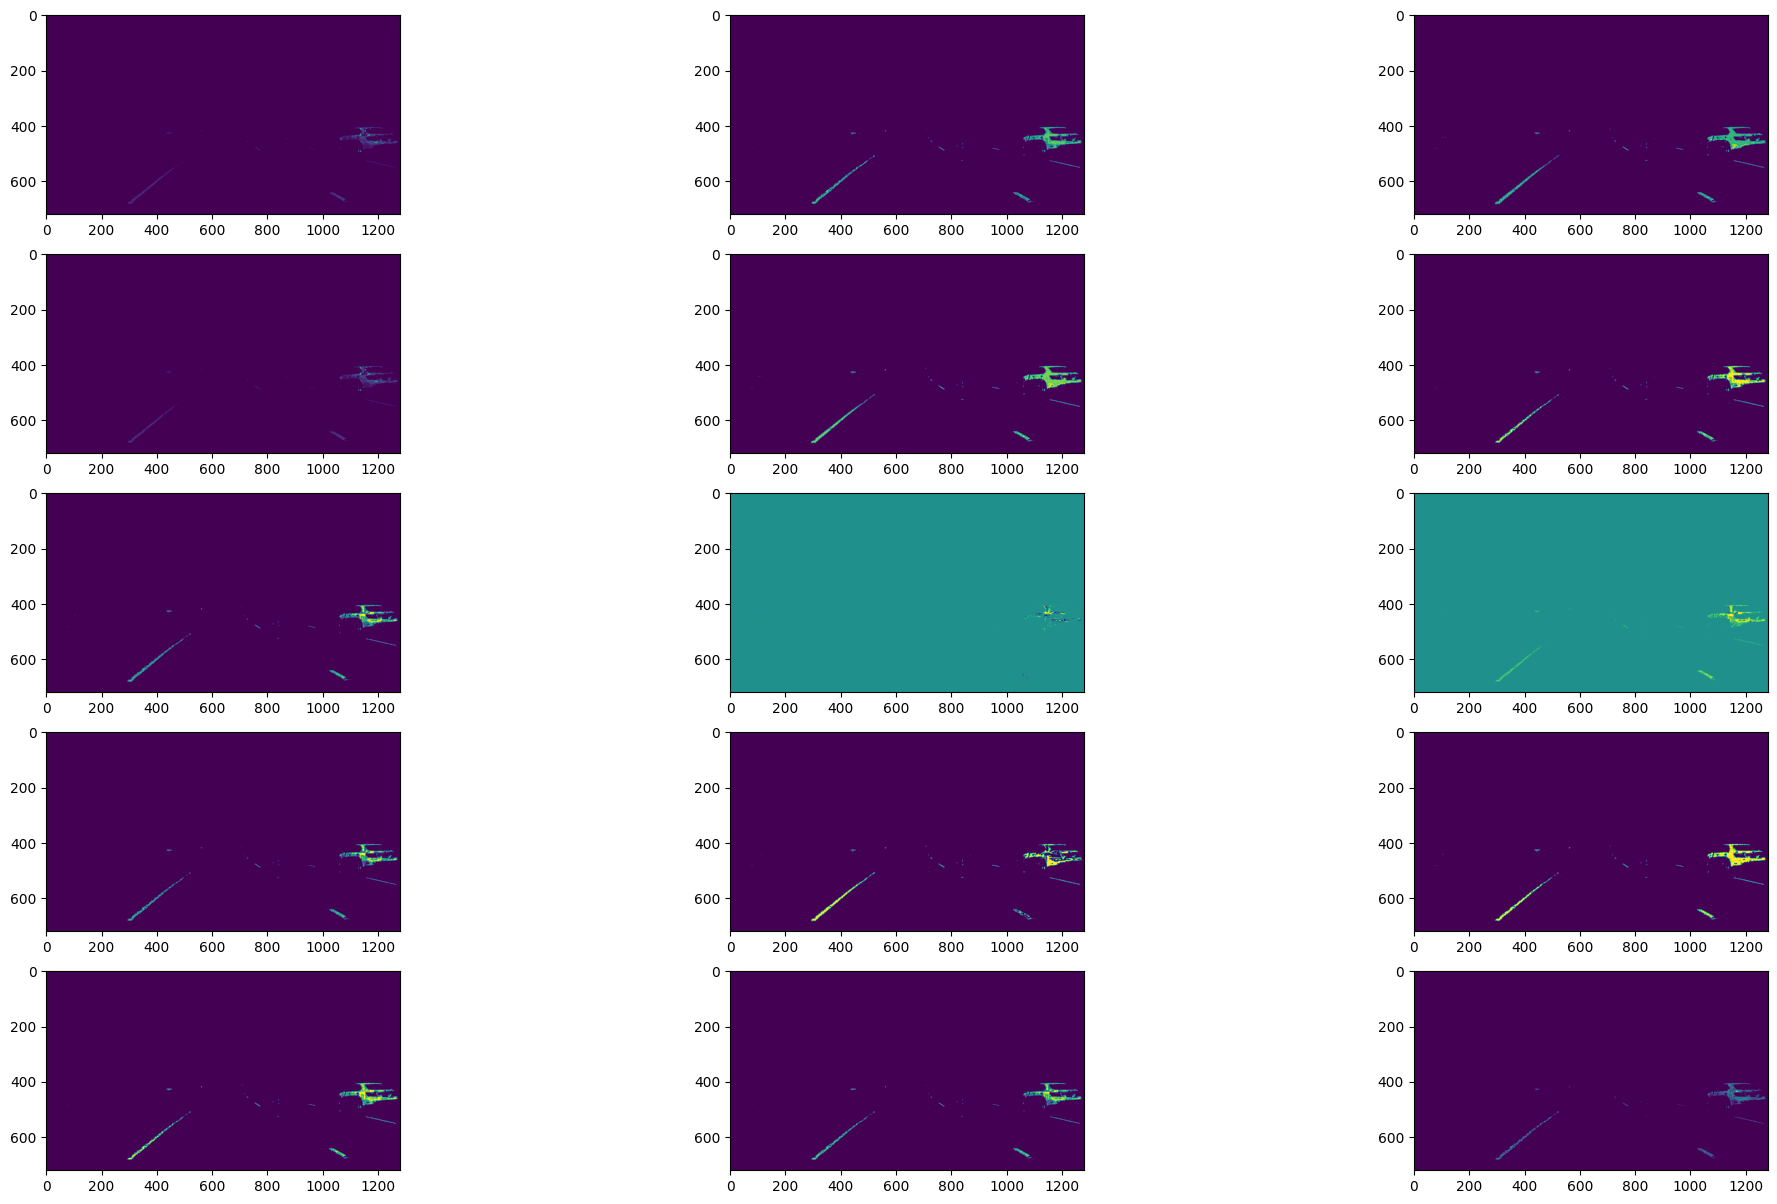

In [3]:
# imports
import cv2 as cv
import numpy as np
import time
from matplotlib import pyplot as plt
import glob
from prettytable import PrettyTable

# size of chessboard, minimum error with (7, 6), but there were severe artefacts at the borders (see error calculation at the end)
x, y = 9, 6

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((y * x, 3), np.float32)
objp[:, :2] = np.mgrid[0:x, 0:y].T.reshape(-1, 2)
# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.


images = glob.glob("./img/Udacity/calib/*.jpg")
for i, fname in enumerate(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (x, y), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(
            gray, corners, (11, 11), (-1, -1), criteria
        )  # improve accuracy of corners
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(
    objpoints, imgpoints, gray.shape[::-1], None, None
)

h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))


def undistort_image(img):
    h, w = img.shape[:2]

    img_undist = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    return img_undist[y : y + h, x : x + w]


# ~50% faster than undistort_image()
def undistort_image_remap(img):
    h, w = img.shape[:2]
    mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w, h), 5)
    dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
    # crop the image
    x, y, w, h = roi
    return dst[y : y + h, x : x + w]

img = cv.imread('./img/Udacity/image003.jpg')
# plt.imshow(img)
# plt.show()

transforms = [cv.COLOR_BGR2HLS, cv.COLOR_BGR2HSV, cv.COLOR_BGR2LAB, cv.COLOR_BGR2LUV, cv.COLOR_BGR2XYZ]
plt.figure(figsize=(25, 15))
j = 1
for i, tr in enumerate(transforms):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)
    
    lim = round(0 + 250)
    v[v < lim] = 0
    v[v >= lim] -= lim

    lim_s = round(255 - 100)
    s[s > lim_s] = 0
    s[s <= lim_s] += lim_s

    final_hsv = cv.merge((h, s, v))
    frame = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    new_img = cv.cvtColor(frame, tr)
    plt.subplot(len(transforms), 3, j)
    plt.imshow(new_img[:,:,0])
    j += 1
    plt.subplot(len(transforms), 3, j)
    plt.imshow(new_img[:,:,1])
    j += 1
    plt.subplot(len(transforms), 3, j)
    plt.imshow(new_img[:,:,2])
    j += 1
plt.show()

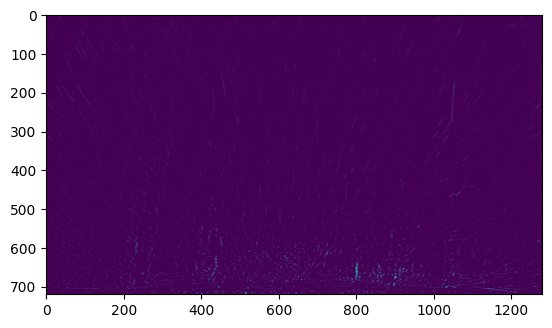

In [7]:
def lane_detection(frame):
    frame = undistort_image_remap(frame)
    src_udacity = np.float32([[191, 628], [531, 404], [1021, 628], [681, 404]])
    dst_udacity = np.float32([[150, 720], [150, 10], [1000, 720], [1000, 10]])
    M_warp = cv.getPerspectiveTransform(src_udacity, dst_udacity)

    frame = cv.warpPerspective(frame, M_warp, (img.shape[1], img.shape[0]))

    frame = cv.GaussianBlur(frame, (5, 5), 0)
    frame_hls = cv.cvtColor(frame, cv.COLOR_BGR2HLS)
    white_mask = cv.inRange(frame_hls, (0, 240, 0), (255, 255, 255))

    frame_lab = cv.cvtColor(frame, cv.COLOR_BGR2LAB)
    yellow_mask = cv.inRange(frame_lab, (150, 100, 150), (255, 140, 200)) #186 129 146

    frame_luv = cv.cvtColor(frame, cv.COLOR_BGR2LUV)
    yellow_mask2 = cv.inRange(frame_luv, (127, 0, 0), (255, 255, 255)) #186 129 146

    canny = cv.Canny(frame, 50, 150)

    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 3))
    black = cv.morphologyEx(frame_lab[:,:, 0], cv.MORPH_TOPHAT, kernel)
    lanes = cv.morphologyEx(frame_hls[:,:,1], cv.MORPH_TOPHAT, kernel)

    kernel = cv.getStructuringElement(cv.MORPH_RECT, (13, 13))
    lanes_yellow = cv.morphologyEx(frame_lab[:, :, 2], cv.MORPH_TOPHAT, kernel)

    combined_mask = cv.bitwise_or(white_mask, yellow_mask, yellow_mask2)
    frame = cv.bitwise_and(frame,frame, mask=combined_mask)
    return lanes_yellow

plt.imshow(lane_detection(img))

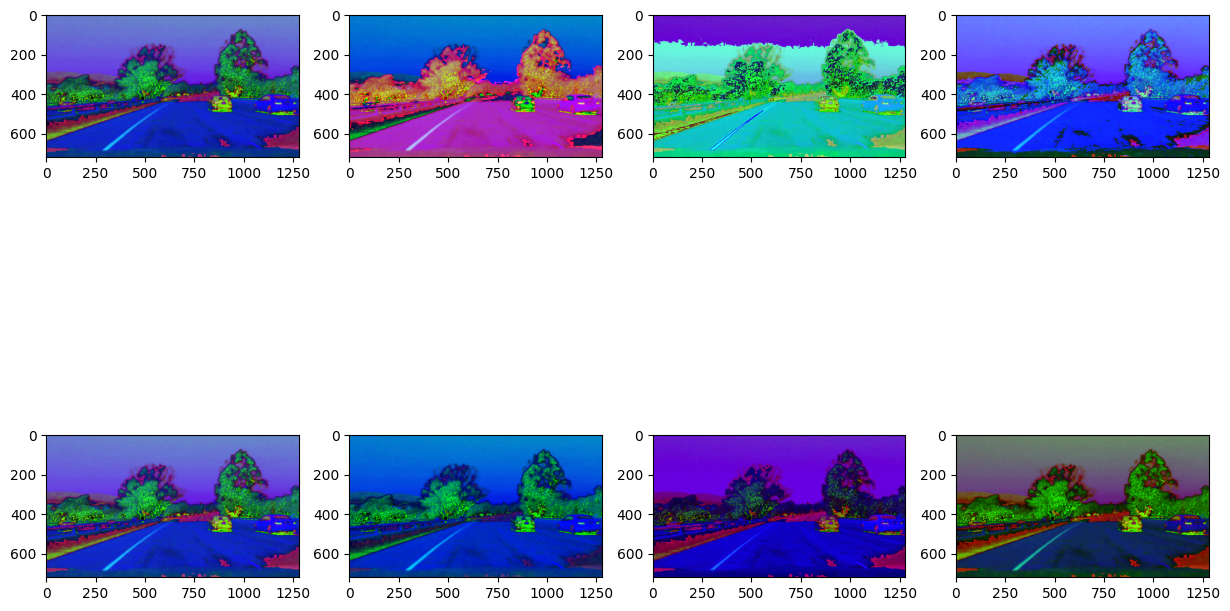

In [5]:
import cv2 as cv
import numpy as np
import time
from matplotlib import pyplot as plt
import glob
from prettytable import PrettyTable

def increase(x, value):
    lim = 255 - value
    x[x > lim] = 255
    x[x <= lim] += lim
    return x

def decrease(x, value):
    lim = 0 + value
    x[x < lim] = 0
    x[x >= lim] -= lim
    return x

img = cv.imread('./img/Udacity/image003.jpg')

hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
h, s, v = cv.split(hsv)

plt.figure(figsize=(15, 10))
plt.subplot(2, 4, 1)
plt.imshow(hsv)


plt.subplot(2, 4, 2)
h, s, v = cv.split(hsv)
plt.imshow(cv.merge((increase(h, 100), s, v)))


plt.subplot(2, 4, 3)
h, s, v = cv.split(hsv)
plt.imshow(cv.merge((h, increase(s, 100), v)))


plt.subplot(2, 4, 4)
h, s, v = cv.split(hsv)
plt.imshow(cv.merge((h, s, increase(v, 100))))



plt.subplot(2, 4, 5)
plt.imshow(hsv)


plt.subplot(2, 4, 6)
h, s, v = cv.split(hsv)
plt.imshow(cv.merge((decrease(h, 100), s, v)))


plt.subplot(2, 4, 7)
h, s, v = cv.split(hsv)
plt.imshow(cv.merge((h, decrease(s, 100), v)))


plt.subplot(2, 4, 8)
h, s, v = cv.split(hsv)
plt.imshow(cv.merge((h, s, decrease(v, 100))))

plt.show()